In [48]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [49]:
plt.rcParams['figure.figsize'] = [15, 6]
folder = 'data/subset_homework'

In [50]:
def load_traffic_data(base_path):
    images = []
    labels = []

    path_0 = os.path.join(base_path, 'class_id_0')
    fnames_0 = os.listdir(path_0)
    for f in fnames_0:
        img = cv2.imread(os.path.join(path_0, f), cv2.IMREAD_UNCHANGED)
        if img is not None:
            images.append(img)
            labels.append(0)

    path_1 = os.path.join(base_path, 'class_id_1')
    fnames_1 = os.listdir(path_1)
    for f in fnames_1:
        img = cv2.imread(os.path.join(path_1, f), cv2.IMREAD_UNCHANGED)
        if img is not None:
            images.append(img)
            labels.append(1)

    return images, labels

In [51]:
images_raw, labels_raw = load_traffic_data(folder)
images_raw, labels_raw = shuffle(images_raw, labels_raw)

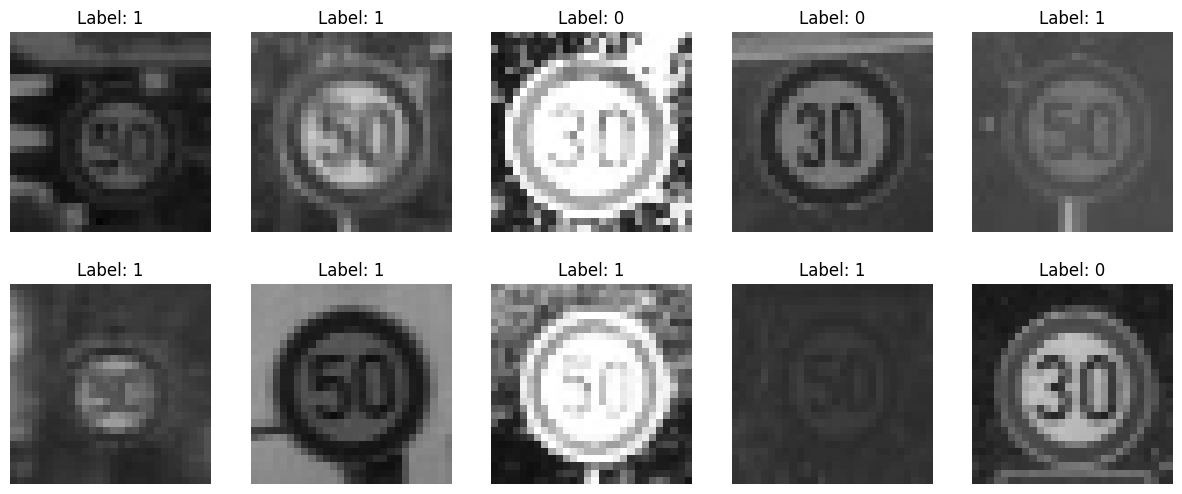

In [52]:
for cnt, idx in enumerate(np.random.randint(0, len(images_raw), 10)):
    plt.subplot(2, 5, cnt+1)
    plt.imshow(images_raw[idx], cmap='gray', vmin=0, vmax=255)
    plt.title(f"Label: {labels_raw[idx]}")
    plt.axis(False)
plt.show()

In [53]:
pixels = np.array([img.flatten() for img in images_raw]) / 255.0
labels = np.array(labels_raw)

X_tensor = torch.tensor(pixels, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)


train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
input_dim = pixels.shape[1]

model_single = nn.Sequential(
    nn.Linear(input_dim, 1)
)

criterion_mse = nn.MSELoss()
optimizer_single = optim.Adam(model_single.parameters(), lr=0.001)

In [55]:
for epoch in range(10):
    model_single.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer_single.zero_grad()
        outputs = model_single(batch_X)
        loss = criterion_mse(outputs, batch_y)
        loss.backward()
        optimizer_single.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.2977
Epoch 2, Loss: 0.2283
Epoch 3, Loss: 0.1973
Epoch 4, Loss: 0.1675
Epoch 5, Loss: 0.1491
Epoch 6, Loss: 0.1376
Epoch 7, Loss: 0.1275
Epoch 8, Loss: 0.1161
Epoch 9, Loss: 0.1105
Epoch 10, Loss: 0.1057


In [56]:
model_single.eval()
correct = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = (model_single(batch_X) > 0.5).float()
        correct += (preds == batch_y).sum().item()
print(f"accuracy (Single Neuron): {correct / test_size:.4f}")

accuracy (Single Neuron): 0.8479


In [57]:
model_deep = nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion_bce = nn.BCELoss()
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001)

In [58]:
for epoch in range(15):
    model_deep.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer_deep.zero_grad()
        outputs = model_deep(batch_X)
        loss = criterion_bce(outputs, batch_y)
        loss.backward()
        optimizer_deep.step()
        total_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 5, Loss: 0.2351
Epoch 10, Loss: 0.2432
Epoch 15, Loss: 0.1359


In [59]:
model_deep.eval()
correct = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = (model_deep(batch_X) > 0.5).float()
        correct += (preds == batch_y).sum().item()
print(f"accuracy (Deep model): {correct / test_size:.4f}")

accuracy (Deep model): 0.9239



Number of errors in the test sample: 68


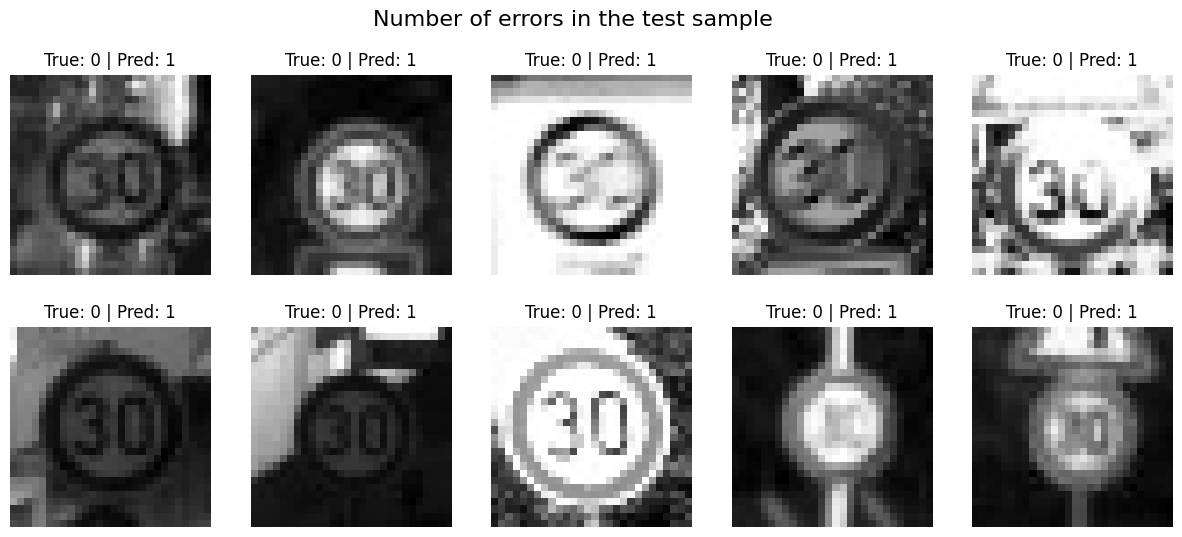

In [60]:
model_deep.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model_deep(batch_X)
        preds = (outputs > 0.5).float()

        mask = (preds != batch_y).numpy().flatten()

        if np.any(mask):
            imgs = batch_X.numpy()[mask]
            lbls = batch_y.numpy()[mask]
            pds = preds.numpy()[mask]

            for i in range(len(imgs)):
                misclassified_images.append(imgs[i])
                misclassified_labels.append(lbls[i])
                misclassified_preds.append(pds[i])

print(f"\nNumber of errors in the test sample: {len(misclassified_images)}")

if len(misclassified_images) > 0:
    plt.figure(figsize=(15, 6))
    plt.suptitle("Number of errors in the test sample", fontsize=16)

    num_to_show = min(len(misclassified_images), 10)
    for i in range(num_to_show):
        plt.subplot(2, 5, i + 1)
        img_to_show = misclassified_images[i].reshape(28, 28)
        plt.imshow(img_to_show, cmap='gray')
        plt.title(f"True: {int(misclassified_labels[i][0])} | Pred: {int(misclassified_preds[i][0])}")
        plt.axis(False)
    plt.show()
else:
    print("100% accuracy")